# Erstes Miniprojekt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

## Generieren der Bilder

In [2]:
import seaborn as sb

GRID_SIZE = 27
SAMPLE_NUM = 3000

np.random.seed(5)
radii = np.random.randint(3,13, size=SAMPLE_NUM)
centers = np.random.randint(28, size=(SAMPLE_NUM, 2))

y, x = np.ogrid[:GRID_SIZE,:GRID_SIZE]
def_weak = np.random.randint(10,20, size=(SAMPLE_NUM))/10
def_heavy = np.random.randint(0,20, size=(SAMPLE_NUM))/20

shapes = ['kreise_ungestoert', 'kreise_schwach_gestoert','kreise_stark_gestoert', 'kreise_mittel_gestoert',
           'kleine_ellipsen_ungestoert', 'große_ellipsen_ungestoert', 'quadrate_ungestoert']

samples = {shape: [] for shape in shapes}


for i, radius in enumerate(radii):
	a, b = centers[i]
	eps_1, eps_2 = def_weak[i], def_heavy[i] 
	# Set-up circular mask
	circ_mask = (x-a)**2 + (y-b)**2 <= radius**2
	# Set up ellipse mask
	ellip_mask_weak = (1+eps_1)*(x-a)**2 + 1/np.sqrt(1+eps_1)*(y-b)**2 <= radius**2
	ellip_mask_heavy = (1+eps_2)*(x-a)**2 + 1/np.sqrt(1+eps_2)*(y-b)**2 <= radius**2
	# Set up square_mask
	square_mask = np.abs(x-a) + np.abs(y-b) <= radius
	
	circs = np.zeros((GRID_SIZE, GRID_SIZE))
	circs[circ_mask] = 255
	
	ellips_heavy = np.zeros((GRID_SIZE, GRID_SIZE))
	ellips_heavy[ellip_mask_heavy] = 255
	
	ellips_weak = np.zeros((GRID_SIZE, GRID_SIZE))
	ellips_weak[ellip_mask_weak] = 255
	
	squares = np.zeros((GRID_SIZE, GRID_SIZE))
	squares[square_mask] = 255
	
	circs = np.reshape(circs, GRID_SIZE**2)
	ellips = np.reshape(ellips_heavy, GRID_SIZE**2)
	ellips_weak = np.reshape(ellips_weak, GRID_SIZE**2)
	squares = np.reshape(squares, GRID_SIZE**2)
	
	circs_very_noisy = np.random.randint(1, 255, GRID_SIZE**2//2)
	circs_very_noisy.resize(GRID_SIZE**2)
	np.random.shuffle(circs_very_noisy)
	circs_very_noisy[circs_very_noisy == 0] = circs[circs_very_noisy == 0]
	
	circs_light_noisy = np.random.randint(1, 255, GRID_SIZE**2//10)
	circs_light_noisy.resize(GRID_SIZE**2)
	np.random.shuffle(circs_light_noisy)
	circs_light_noisy[circs_light_noisy == 0] = circs[circs_light_noisy == 0]
	
	circs_med_noisy = np.random.randint(1, 255, GRID_SIZE**2//5)
	circs_med_noisy.resize(GRID_SIZE**2)
	np.random.shuffle(circs_med_noisy)
	circs_med_noisy[circs_med_noisy == 0] = circs[circs_med_noisy == 0]
	
	samples['kreise_ungestoert'].append(np.reshape(circs, GRID_SIZE**2))
	samples['große_ellipsen_ungestoert'].append(ellips)
	samples['kleine_ellipsen_ungestoert'].append(ellips_weak)
	samples['quadrate_ungestoert'].append(squares)
	samples['kreise_stark_gestoert'].append([circs_very_noisy])
	samples['kreise_mittel_gestoert'].append([circs_med_noisy])
	samples['kreise_schwach_gestoert'].append([circs_light_noisy])

for key, values in samples.items():
	frame = pd.DataFrame(np.vstack(values))
	print(f'Habe in {key}.json geschrieben ...')
	frame.to_json(f'{key}.json', orient='records')

# Set-up for supervised-learning
supervised = pd.DataFrame(centers).rename({0:'center_x', 1:'center_y'}, axis='columns')
supervised['radius'] = radii
print(supervised.columns)
supervised.to_json('kreise_ungestoert_supervised.json', orient='records')


rad_hist = sb.histplot(radii, discrete=True)
rad_hist.set_title('Verteilung der Radien in den Samples')
rad_hist.set_xlabel('Radius in px')
rad_hist.set_ylabel('Anzahl')
plt.show()

Habe in kreise_ungestoert.json geschrieben ...
Habe in kreise_schwach_gestoert.json geschrieben ...
Habe in kreise_stark_gestoert.json geschrieben ...
Habe in kreise_mittel_gestoert.json geschrieben ...
Habe in kleine_ellipsen_ungestoert.json geschrieben ...
Habe in große_ellipsen_ungestoert.json geschrieben ...
Habe in quadrate_ungestoert.json geschrieben ...
Index(['center_x', 'center_y', 'radius'], dtype='object')


## Autoencoder

In [3]:
latent_dim = 49

class Autoencoder(Model):
	def __init__(self, latent_dim):
		super(Autoencoder, self).__init__()
		self.latent_dim = latent_dim   
		self.encoder = tf.keras.Sequential([
			layers.Conv2D(4, 5, activation='sigmoid', padding='same', input_shape=(None, None, 1)),
			layers.AveragePooling2D(pool_size=(3,3), padding='same'),
			layers.Conv2D(4, 5, activation='sigmoid', padding='same'),
			layers.AveragePooling2D(pool_size=(3,3), padding='same'),
			layers.Conv2D(1, 3, activation='sigmoid', padding='same') 
		])
		
		self.decoder = tf.keras.Sequential([
			layers.UpSampling2D(size=(3,3)),
			layers.Conv2D(4, 5, activation='sigmoid', padding='same'),
			layers.UpSampling2D(size=(3,3)),
			layers.Conv2D(4, 5, activation='sigmoid', padding='same'),
			layers.Conv2D(1, 3, activation='linear', padding='same'),
        ])

	def call(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


frame = pd.read_json('kreise_ungestoert.json')
x_train, x_test = train_test_split(frame, random_state=5, test_size=0.6)
x_test = np.reshape(np.array(x_test), (x_test.shape[0], 27, 27, 1))/255
x_train = np.reshape(np.array(x_train), (x_train.shape[0], 27, 27, 1))/255

autoencoder = Autoencoder(latent_dim)
print(autoencoder.encoder.summary())
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = autoencoder.fit(x_train, x_train, epochs=100,
                shuffle=True, validation_data=(x_test, x_test), batch_size=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 4)     104       
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 4)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     404       
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 4)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     37        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
120/120 [==============================] - 4s 28ms/step - loss: 0.1999 - val_loss: 0.1565

## Plots

JSON-Dateien in diesem Ordner:
kreise_schwach_gestoert.json
kleine_ellipsen_ungestoert.json
kreise_ungestoert_supervised.json


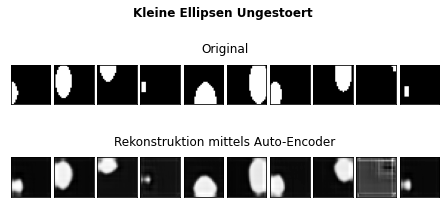

ValueError: cannot reshape array of size 30 into shape (10,27,27,1)

In [4]:
def create_row_title(row_num: int, title: str):
	spec = fig.add_gridspec(2, n)
	row = fig.add_subplot(spec[row_num, :])
	row.set_title(f'{title}')
	# hide subplot
	row.set_frame_on(False)
	row.axis('off')

n = 10

print('JSON-Dateien in diesem Ordner:')

for root, dirs, files in os.walk(os.path.curdir):
	for file in files:
		if file.split('.')[-1] == 'json':
			print(file)
			data_for_plot = pd.read_json(file, orient='record').head(n)
			data_for_plot = np.reshape(np.array(data_for_plot), (n, 27, 27, 1))/255
			encoded = autoencoder.encoder(data_for_plot)
			decoded = autoencoder.decoder(encoded).numpy()
			
			fig, axs = plt.subplots(2, n)
			spec = fig.add_gridspec(2, n)
			create_row_title(0, 'Original')
			create_row_title(1, 'Rekonstruktion mittels Auto-Encoder')
			
			for i in range(n):
				  # display original
				  subplt = axs[0, i]
				  subplt.imshow(-data_for_plot[i], cmap='binary')
				  subplt.get_xaxis().set_visible(False)
				  subplt.get_yaxis().set_visible(False)
					
				  # display reconstruction
				  subplt = axs[1, i]
				  subplt.imshow(-np.reshape(decoded[i], (27,27)), cmap='binary')
				  subplt.get_xaxis().set_visible(False)
				  subplt.get_yaxis().set_visible(False)
			fig.tight_layout(pad=0)
			plt.subplots_adjust(bottom=0.3, top=0.8, hspace=.8)
			fig.suptitle(file.split('.')[0].replace('_', ' ').title(), fontweight='bold')
			plt.savefig(f"plots/{file.split('.')[0]}.png", dpi=1000)
			plt.show()

In [ ]:
# Plot training history
plt.title('Traningsfortschritt')
plt.tick_params('x', direction='in', top=True)
plt.tick_params('y', direction='in', right=True)
plt.plot(history.history['loss'], label='Trainingsdaten')
plt.plot(history.history['val_loss'], label='Testdaten')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/trainings_historie.png', dpi=1000)
plt.show()

## Supervised learning zum Vergleich



In [ ]:
y = pd.read_json('kreise_ungestoert_supervised.json', orient='records')
x = pd.read_json('kreise_ungestoert.json', orient='records')

print(y)
print('Sliced DataFrame.')

# Train-test-split
x_train, x_test, y_train, y_test = train_test_split(x,y ,random_state=5, test_size=0.6)

supervised_model = tf.keras.Sequential([
	layers.LayerNormalization(input_shape=(None, 1)),
	layers.Conv1D(10, 5, padding='same'),
	#layers.AveragePooling1D(pool_size=9, padding='same'),
	layers.Conv1D(1, 3, padding='same'),
	layers.Reshape((729,)),
	#layers.Conv1D(4, 5, activation='sigmoid', padding='same', input_shape=(None, 1)),
	#layers.AveragePooling1D(pool_size=9, padding='same'),
	#layers.Conv1D(4, 5, activation='sigmoid', padding='same', input_shape=(None, 1)),
	#layers.AveragePooling1D(pool_size=3, padding='same'),
	layers.Dense(12, activation='relu'),
	layers.Dense(3),
	#layers.Reshape((3,))
])

supervised_model.summary()
supervised_model.compile(optimizer='adam', loss=losses.MeanSquaredError())

x_test = np.reshape(np.array(x_test), (x_test.shape[0], 729, 1))/255
x_train = np.reshape(np.array(x_train), (x_train.shape[0], 729, 1))/255
history = supervised_model.fit(x_train/255, y_train, epochs=10,
                shuffle=True, validation_data=(x_test/255, y_test), batch_size=20)
model_out = supervised_model.predict(x_test[:10])
print(model_out[:10])
print(y_test[:10])

In [ ]:
frame = pd.DataFrame(centers[:10]).rename({0:'center_x', 1:'center_y'}, axis='columns')
frame['radius'] = radii[:10]
frame
